# Cocofluo 
**Confocal Cell Segmentation & Fluorescence Colocalization Pipeline**

### Project Overview | 项目概述

Cocofluo Detection is an automated bioimage analysis pipeline designed for processing multi-channel confocal microscopy images. The goal of this project is to perform robust single-cell instance segmentation from large-scale cellular images and to enable downstream quantitative analysis of fluorescence marker distributions and colocalization at the individual cell level.

The pipeline takes confocal images containing a structural cell channel and multiple fluorescence marker channels as input. It first identifies and segments every individual cell within the field of view, producing an instance-level segmentation mask that serves as the coordinate reference for all subsequent analysis.  
Based on this segmentation, the system will later quantify fluorescence signals within each cell and determine whether different markers are colocalized according to predefined spatial overlap criteria.

The long-term objective is to build a fully automated workflow from raw confocal images to per-cell fluorescence quantification and colocalization detection.

Cocofluo Detection 是一个面向多通道共聚焦显微图像的自动化生物图像分析流程，目标是在大尺度细胞图像中实现稳定、精确的单细胞实例分割，并在此基础上完成荧光标记的单细胞定量分析与共定位检测。

该系统以包含细胞结构通道与多个荧光标记通道的 confocal 图像为输入，首先自动识别并分割视野中的每一个细胞实例，生成实例级分割掩膜（instance mask），作为后续所有分析的统一空间坐标系。 在此基础上，后续模块将针对每个细胞独立分析不同荧光标记的分布情况，并根据预定义规则判断其是否发生共定位。

项目的长期目标是构建从原始共聚焦图像到单细胞荧光特征提取与共定位判定的全自动分析 pipeline。

---

#### Block 1 — Model & Environment Check ｜ 模型与环境识别
 
This block verifies the current Cellpose version and available model interfaces, ensuring compatibility with the v4+ `CellposeModel` API and confirming GPU/CPU inference configuration. This step prevents version mismatch issues and clarifies which pretrained segmentation model is being used.
 
该模块用于确认当前环境中 Cellpose 的版本与可用模型接口，确保使用 v4+ 的 `CellposeModel` 推理方式，并检查 GPU/CPU 推理配置，避免版本不兼容问题，同时明确当前分割模型的来源。


In [1]:
import sys, os
import cellpose
from cellpose import models

print("Python:", sys.version)
print("cellpose version:", getattr(cellpose, "__version__", "unknown"))
print("cellpose path:", cellpose.__file__)
print("cellpose.models path:", models.__file__)

print("\nHas models.Cellpose ?", hasattr(models, "Cellpose"))
print("Has models.CellposeModel ?", hasattr(models, "CellposeModel"))
print("Has models.CellposeSegmentator ?", hasattr(models, "CellposeSegmentator"))

Python: 3.10.19 | packaged by conda-forge | (main, Jan 26 2026, 23:45:08) [GCC 14.3.0]
cellpose version: unknown
cellpose path: /home/ningwei3/.conda/envs/cellpose_env/lib/python3.10/site-packages/cellpose/__init__.py
cellpose.models path: /home/ningwei3/.conda/envs/cellpose_env/lib/python3.10/site-packages/cellpose/models.py

Has models.Cellpose ? False
Has models.CellposeModel ? True
Has models.CellposeSegmentator ? False


#### Block 2 — Data Inspection & Channel Preview ｜ 数据结构检查与通道可视化

This block loads the raw confocal image, inspects its dimensional structure (shape, channels, data type), and visualizes each channel separately. The purpose is to identify which channel represents cellular structure and which channels correspond to fluorescence markers, preventing incorrect channel usage in segmentation.

该模块用于读取原始多通道共聚焦图像，检查其数据结构（维度、通道数、数据类型），并对各通道进行可视化展示，以确认细胞结构通道与荧光标记通道的对应关系，避免后续分割输入错误。


raw shape: (4, 3903, 5719) | dtype: uint8 | ndim: 3


<Figure size 600x600 with 0 Axes>

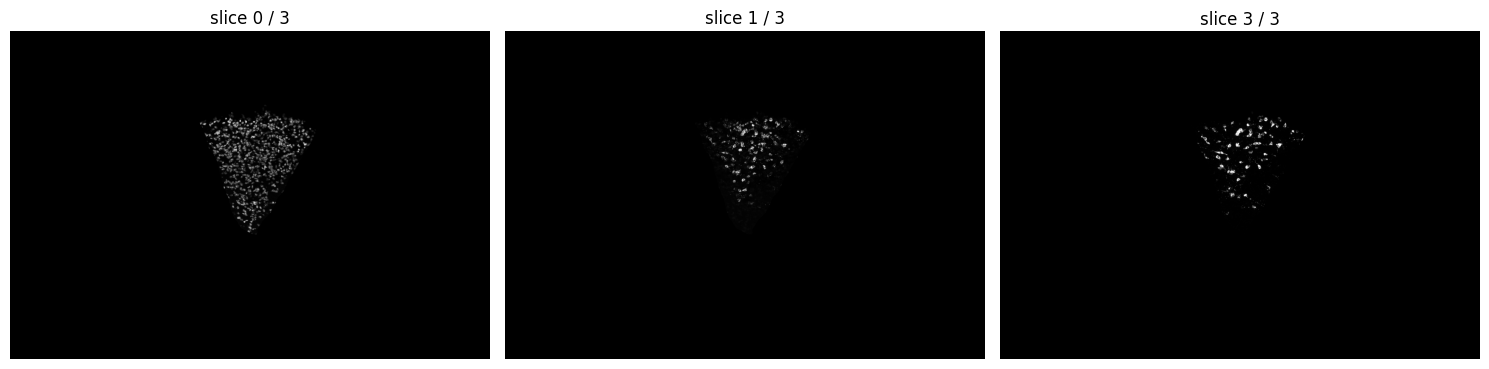

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import io

MY_IMAGE_PATH = "data/test2.tif"

img = io.imread(MY_IMAGE_PATH)
print("raw shape:", img.shape, "| dtype:", img.dtype, "| ndim:", img.ndim)

plt.figure(figsize=(6,6))

if img.ndim == 2:
    plt.imshow(img, cmap="gray")
    plt.title("2D image")
    
elif img.ndim == 3:
    idxs = [0, min(1, img.shape[0]-1), img.shape[0] -1]
    fig, axes = plt.subplots(1, len(idxs), figsize=(15, 5))
    for ax, i in zip(axes, idxs):
        ax.imshow(img[i], cmap="gray")
        ax.set_title(f"slice {i} / {img.shape[0]-1}")
        ax.axis("off")
    plt.tight_layout()

elif img.ndim == 4:
    print("4D image detected, need axis interpretation.")
    print("shape breakdown:", img.shape)
    
else:
    print("Unsupported ndim:", img.ndim)

plt.show()

#### Block 3 — Preprocessing & Normalization ｜ 数据增强与标准化预处理

This block applies contrast stretching and robust normalization to the selected cell structural channel. The goal is to enhance weak cellular boundaries, suppress extreme intensity values, and map the image into a distribution more suitable for deep learning–based segmentation.
 
该模块对选定的细胞结构通道进行稳健归一化与对比度拉伸，增强弱边界结构，抑制异常亮度值，使图像分布更适合深度学习模型输入，从而提升分割稳定性与鲁棒性。


cell shape: (3903, 5719) min/max: 0.0 255.0


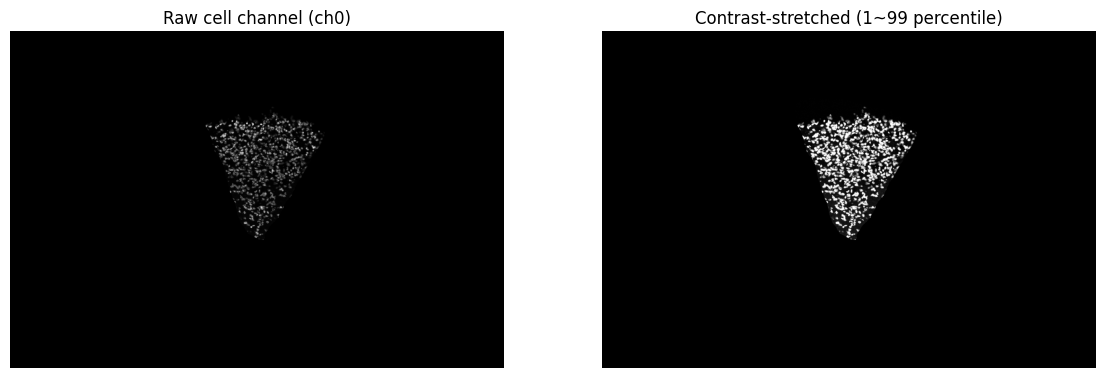

[SAVE] data/test1_cell_ch0_contrast.tif


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import io

MY_IMAGE_PATH = "data/test2.tif"
img = io.imread(MY_IMAGE_PATH)

cell = img[0].astype(np.float32)   # 第0层是cell
print("cell shape:", cell.shape, "min/max:", cell.min(), cell.max())

p1, p99 = np.percentile(cell, (1, 99))
cell_norm = np.clip((cell - p1) / (p99 - p1 + 1e-8), 0, 1)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(cell, cmap="gray")
plt.title("Raw cell channel (ch0)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cell_norm, cmap="gray")
plt.title("Contrast-stretched (1~99 percentile)")
plt.axis("off")
plt.show()

save_path = os.path.join("data", "test1_cell_ch0_contrast.tif")
io.imsave(save_path, (cell_norm * 255).astype(np.uint8))
print("[SAVE]", save_path)

#### Block 4 — Segmentation & Mask Export ｜ 细胞实例分割与掩膜输出
 
This block loads the pretrained Cellpose model and performs instance segmentation to automatically detect all individual cells in the image. The resulting instance mask (label map) is exported in standard formats and serves as the fundamental reference for all downstream single-cell analyses.

该模块调用 Cellpose 预训练模型执行细胞实例分割，自动识别图像中所有细胞并区分独立个体。输出实例级掩膜（label map），并保存为标准中间结果文件，作为后续所有单细胞分析的基础坐标系。

In [6]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, plot, io

MY_IMAGE_PATH = "data/test2.tif"
OUTPUT_DIR = "cell_results"
USE_GPU = True
os.makedirs(OUTPUT_DIR, exist_ok=True)

#读图 + 取 cell 通道
img = io.imread(MY_IMAGE_PATH)
cell = img[0].astype(np.float32)

#对比度拉伸
p1, p99 = np.percentile(cell, (1, 99))
cell_norm = np.clip((cell - p1) / (p99 - p1 + 1e-8), 0, 1).astype(np.float32)

print("Input:", cell_norm.shape, cell_norm.dtype, cell_norm.min(), cell_norm.max())

#加载模型（v4.0.1+ 不再用 model_type）
model = models.CellposeModel(gpu=USE_GPU)

#推理（v4.0.1+ 返回 3 个：masks flows styles）
t0 = time.time()
masks, flows, styles = model.eval(
    cell_norm,
    diameter=None,
    flow_threshold=0.4,
    cellprob_threshold=0.0
)
t1 = time.time()

num_cells = int(masks.max())
print(f"Done. time={t1-t0:.2f}s | cells={num_cells}")

#保存 label mask
base = os.path.splitext(os.path.basename(MY_IMAGE_PATH))[0]
npy_path = os.path.join(OUTPUT_DIR, f"{base}_masks.npy")
tif_path = os.path.join(OUTPUT_DIR, f"{base}_masks_label.tif")
np.save(npy_path, masks.astype(np.int32))
io.imsave(tif_path, masks.astype(np.uint16))
print("[SAVE]", npy_path)
print("[SAVE]", tif_path)

Input: (3903, 5719) float32 0.0 1.0
Done. time=19.70s | cells=671
[SAVE] cell_results/test2_masks.npy
[SAVE] cell_results/test2_masks_label.tif


#### Block 5 — Visualization & Quality Control ｜ 可视化与人工核查
 
This block generates multiple visualization outputs, including colorful instance masks, overlays of masks on the original image, and multi-page or multi-channel files. These outputs support rapid human quality control, error inspection, and communication with experimental collaborators.
 
该模块基于分割结果生成多种可视化图像，包括彩色细胞标记图、原图与掩膜叠加图以及多页/多通道文件，用于快速人工核查分割质量、发现分割错误，并辅助与实验人员沟通与对比。


[SAVE] cell_results/test2_mask_rgb.png
[SAVE] cell_results/test2_overlay_rgb.png


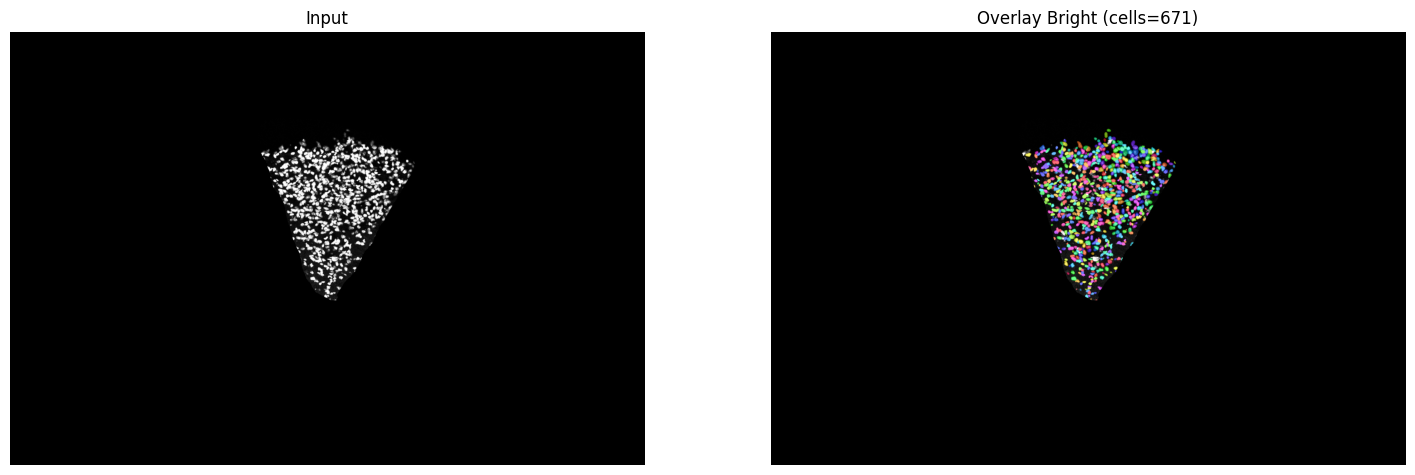

[SAVE] cell_results/test2_overlay_matplotlib.png


In [7]:
def hsv_to_rgb(h, s, v):
    import colorsys
    h = np.asarray(h); s = np.asarray(s); v = np.asarray(v)
    out = np.zeros(h.shape + (3,), dtype=np.float32)
    flat_h = h.ravel(); flat_s = s.ravel(); flat_v = v.ravel()
    out_flat = out.reshape(-1, 3)
    for i in range(flat_h.size):
        out_flat[i] = colorsys.hsv_to_rgb(float(flat_h[i]), float(flat_s[i]), float(flat_v[i]))
    out = (out * 255.0).clip(0, 255).astype(np.uint8)
    return out

def make_bright_mask_rgb(masks, seed=123, s=1.0, v=1.0):
    H, W = masks.shape
    n = int(masks.max())
    rng = np.random.RandomState(seed)

    hues = rng.rand(n + 1).astype(np.float32)  # 0 留给背景
    hues[0] = 0.0

    hsv_h = hues
    hsv_s = np.full_like(hsv_h, fill_value=s, dtype=np.float32)
    hsv_v = np.full_like(hsv_h, fill_value=v, dtype=np.float32)
    lut = hsv_to_rgb(hsv_h, hsv_s, hsv_v)  # (n+1,3) uint8

    mask_rgb = lut[masks]  # (H,W,3)
    mask_rgb[masks == 0] = 0
    return mask_rgb

def make_overlay(gray01, mask_rgb, alpha=0.55):
    gray_u8 = (gray01 * 255.0).clip(0, 255).astype(np.uint8)
    gray_rgb = np.stack([gray_u8, gray_u8, gray_u8], axis=-1).astype(np.float32)   # (H,W,3)

    mask_f = mask_rgb.astype(np.float32)  # (H,W,3)

    m2d = (mask_rgb.sum(axis=-1) > 0).astype(np.float32)  # (H,W) 0/1
    m3d = m2d[..., None]  # (H,W,1) 会广播到 (H,W,3)

    overlay = gray_rgb * (1.0 - alpha * m3d) + mask_f * (alpha * m3d)
    overlay = overlay.clip(0, 255).astype(np.uint8)
    return overlay, gray_rgb.astype(np.uint8), gray_u8


mask_rgb = make_bright_mask_rgb(masks, seed=123, s=1.0, v=1.0)
overlay_rgb, gray_rgb, raw_u8 = make_overlay(cell_norm, mask_rgb, alpha=0.55)

mask_rgb_png = os.path.join(OUTPUT_DIR, f"{base}_mask_rgb.png")
io.imsave(mask_rgb_png, mask_rgb)
print("[SAVE]", mask_rgb_png)

overlay_png = os.path.join(OUTPUT_DIR, f"{base}_overlay_rgb.png")
io.imsave(overlay_png, overlay_rgb)
print("[SAVE]", overlay_png)

plt.figure(figsize=(18, 8))
plt.subplot(1,2,1); plt.imshow(cell_norm, cmap="gray"); plt.title("Input"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay_rgb); plt.title(f"Overlay Bright (cells={num_cells})"); plt.axis("off")
viz_path = os.path.join(OUTPUT_DIR, f"{base}_overlay_matplotlib.png")
plt.savefig(viz_path, dpi=150, bbox_inches="tight")
plt.show()
print("[SAVE]", viz_path)

In [8]:
import os
import numpy as np
import tifffile as tiff

two_page_path = os.path.join(OUTPUT_DIR, f"{base}_raw_vs_mask_2page.tif")

with tiff.TiffWriter(two_page_path, bigtiff=True) as tw:

    tw.write(raw_u8, photometric="minisblack")
    tw.write(mask_rgb, photometric="rgb")

print("[SAVE]", two_page_path)

[SAVE] cell_results/test2_raw_vs_mask_2page.tif


#### Block 6 — Marker Channel Loading ｜ 荧光通道读取
 
Load the multi-channel confocal image and extract the specified fluorescence marker channel. This block isolates the raw fluorescence intensity map that will be used for downstream thresholding and analysis.

读取多通道共聚焦图像，并提取指定的荧光 marker 通道。该步骤得到原始荧光强度分布图，是后续阈值提取与分析的基础数据层。


raw img shape: (4, 3903, 5719) uint8
marker shape: (3903, 5719) float32 range: 0.0 255.0


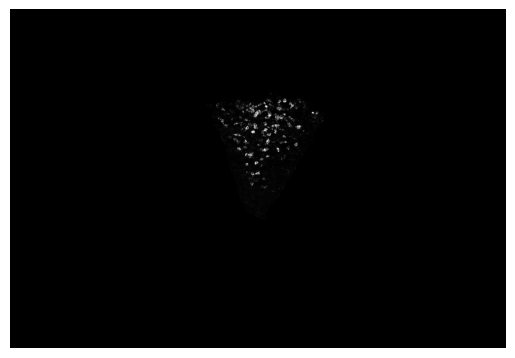

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from cellpose import io

MY_IMAGE_PATH = "data/test2.tif" 
MARKER_CH_IDX = 1
OUTPUT_DIR = "cell_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

img = io.imread(MY_IMAGE_PATH)
marker = img[MARKER_CH_IDX].astype(np.float32)

print("raw img shape:", img.shape, img.dtype)
print("marker shape:", marker.shape, marker.dtype, "range:", float(marker.min()), float(marker.max()))

plt.imshow(marker, cmap="gray")
plt.axis("off")
plt.show()

#### Block 7 — Marker Thresholding ｜ 荧光信号阈值化（二进制提取）
 
Apply a fixed or percentile-based intensity threshold to the fluorescence channel to generate a binary marker mask. Pixels above the threshold are treated as marker-positive regions, while all others are set as background.

对荧光通道进行阈值化处理，生成二值 marker 图（binary bitmap）。强度高于阈值的像素被视为 marker 阳性区域，其余区域视为背景。


In [10]:
P = 99.8 # 取 top 0.2% 当作强阳性
THRESH_P = np.percentile(marker, P)
marker_bin_p = (marker > THRESH_P).astype(np.uint8)

print("percentile:", P, "=> thresh:", float(THRESH_P))
print("positive pixels:", int(marker_bin_p.sum()), "/", marker_bin_p.size)

percentile: 99.8 => thresh: 86.0
positive pixels: 44398 / 22321257


#### Block 8 — Visual Inspection ｜ 阈值结果快速可视化检查

Visualize the raw marker channel and its corresponding binary mask side-by-side to validate threshold selection and inspect noise, background, and signal distribution.

并排展示原始 marker 图与二值结果，用于人工检查阈值合理性、信号分布情况以及背景噪声水平。

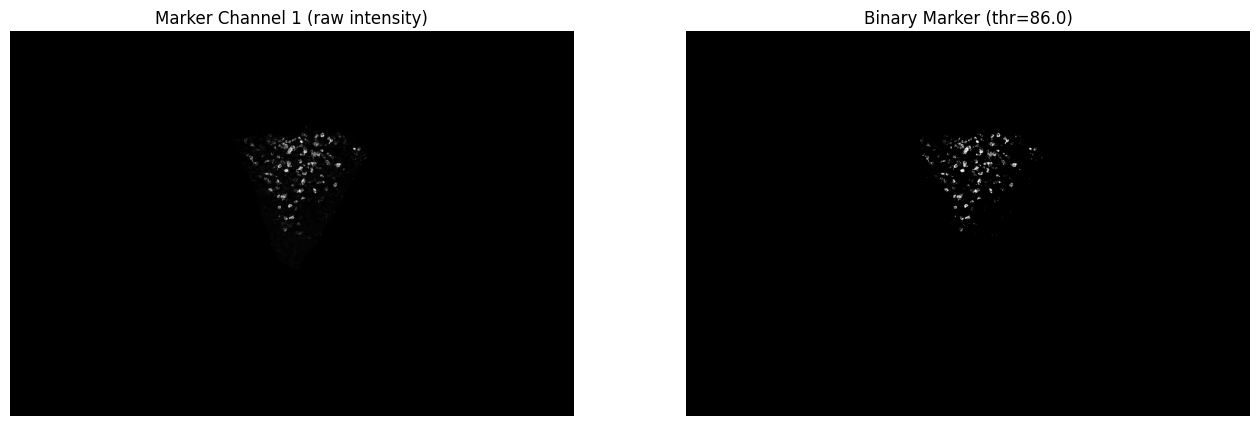

In [11]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.imshow(marker, cmap="gray")
plt.title(f"Marker Channel {MARKER_CH_IDX} (raw intensity)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(marker_bin_p, cmap="gray")
plt.title(f"Binary Marker (thr={THRESH_P})")
plt.axis("off")

plt.show()

#### Block 9 — Marker Mask Export ｜ Marker 二值掩膜保存

Export the binary marker mask into standard intermediate formats (.npy and .tif). These files serve as reusable intermediate data for downstream single-cell overlap and colocalization analysis.
 
将二值 marker 掩膜保存为标准中间文件格式（.npy 与 .tif），作为后续单细胞统计与共定位分析的输入数据。


In [12]:
base = os.path.splitext(os.path.basename(MY_IMAGE_PATH))[0]
npy_path = os.path.join(OUTPUT_DIR, f"{base}_marker_ch{MARKER_CH_IDX}_bin.npy")
tif_path = os.path.join(OUTPUT_DIR, f"{base}_marker_ch{MARKER_CH_IDX}_bin.tif")

np.save(npy_path, marker_bin_p.astype(np.uint8))
io.imsave(tif_path, (marker_bin_p * 255).astype(np.uint8))

print("[SAVE]", npy_path)
print("[SAVE]", tif_path)

[SAVE] cell_results/test2_marker_ch1_bin.npy
[SAVE] cell_results/test2_marker_ch1_bin.tif



#### Block 10 — Visualization & Quality Control Artifacts ｜ 对比图与多层文件生成（人工核查）

Generate visual quality control artifacts including:  
(1) a comparison figure showing raw marker vs. detected marker regions,  
(2) standalone raw and color-coded binary images, and  
(3) a two-page TIFF file allowing rapid layer switching for manual inspection.

生成多种用于人工核查的可视化产物，包括：  
（1）原始 marker 与识别结果的并排对比图，  
（2）独立保存的原图与彩色二值 marker 图，  
（3）可上下切换图层的双页 TIFF 文件，便于快速人工比对。


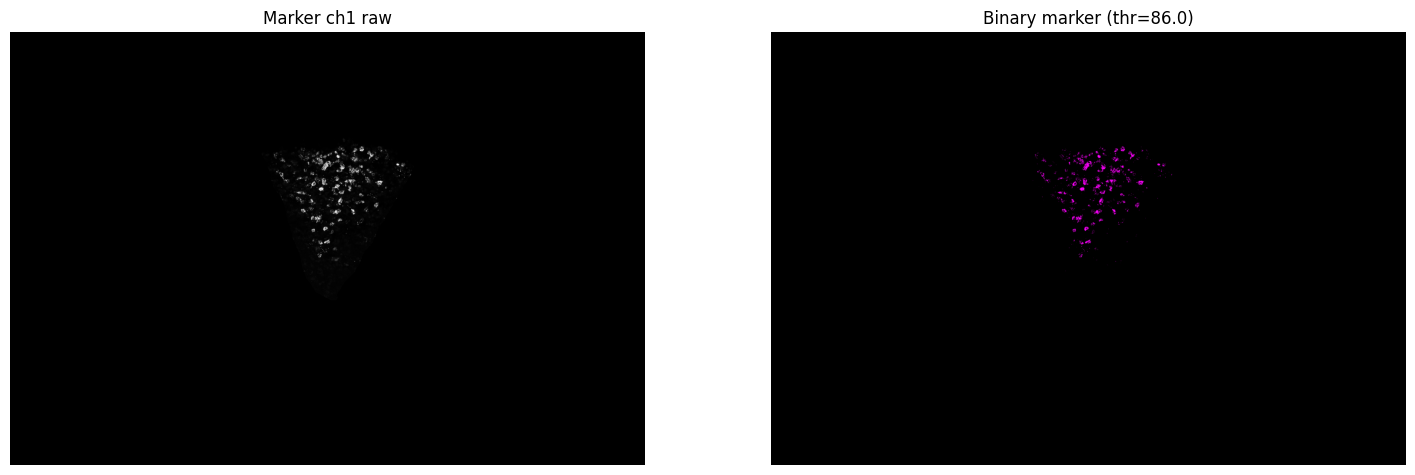

[SAVE compare] cell_results/test2_marker_ch1_compare.png
[SAVE] cell_results/test2_marker_ch1_raw.png
[SAVE] cell_results/test2_marker_ch1_bin_color.png
[SAVE] cell_results/test2_marker_ch1_raw_vs_bincolor_2page.tif


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

def to_u8(img2d):
    x = img2d.astype(np.float32)
    mn, mx = float(x.min()), float(x.max())
    if mx <= mn + 1e-8:
        return np.zeros_like(x, dtype=np.uint8)
    y = (x - mn) / (mx - mn)
    return (y * 255).clip(0,255).astype(np.uint8)

def make_color_mask(bin_mask, color=(0, 255, 0)):
    rgb = np.zeros((bin_mask.shape[0], bin_mask.shape[1], 3), dtype=np.uint8)
    rgb[bin_mask > 0] = np.array(color, dtype=np.uint8)
    return rgb

raw_u8 = to_u8(marker)
mask_rgb = make_color_mask(marker_bin_p, color=(255, 0, 255))

plt.figure(figsize=(18, 7))

plt.subplot(1,2,1)
plt.imshow(raw_u8, cmap="gray")
plt.title(f"Marker ch{MARKER_CH_IDX} raw")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask_rgb)
plt.title(f"Binary marker (thr={THRESH_P})")
plt.axis("off")

cmp_path = os.path.join(OUTPUT_DIR, f"{base}_marker_ch{MARKER_CH_IDX}_compare.png")
plt.savefig(cmp_path, dpi=150, bbox_inches="tight")
plt.show()

print("[SAVE compare]", cmp_path)

plt.show()

base = os.path.splitext(os.path.basename(MY_IMAGE_PATH))[0]
raw_png  = os.path.join(OUTPUT_DIR, f"{base}_marker_ch{MARKER_CH_IDX}_raw.png")
mask_png = os.path.join(OUTPUT_DIR, f"{base}_marker_ch{MARKER_CH_IDX}_bin_color.png")

plt.imsave(raw_png, raw_u8, cmap="gray")
plt.imsave(mask_png, mask_rgb)

print("[SAVE]", raw_png)
print("[SAVE]", mask_png)

two_page_path = os.path.join(
    OUTPUT_DIR, f"{base}_marker_ch{MARKER_CH_IDX}_raw_vs_bincolor_2page.tif"
)

with tiff.TiffWriter(two_page_path, bigtiff=True) as tw:
    tw.write(raw_u8, photometric="minisblack")
    tw.write(mask_rgb, photometric="rgb")

print("[SAVE]", two_page_path)


#### Block 11 — Single-Cell Marker Expression Analysis ｜ 单细胞尺度的荧光 Marker 表达判定与结果可视化


Determine whether each segmented cell expresses a given fluorescence marker based on the spatial overlap between the cell mask and the binary marker mask. Cells are classified as marker-positive if the marker-covered area exceeds a predefined fraction of the cell area. The final output highlights only marker-expressing cells while preserving the original grayscale background for all others.

基于细胞分割结果与荧光 marker 二值掩膜，在单细胞尺度判定 marker 是否被表达。若 marker 在某一细胞内的覆盖面积占该细胞总面积超过设定阈值，则认为该细胞表达该 marker。最终结果仅对表达的细胞进行彩色高亮，其余细胞保持原始灰度底图。


[EXPRESS] threshold=0.150 | express_cells=77 / total_cells=671


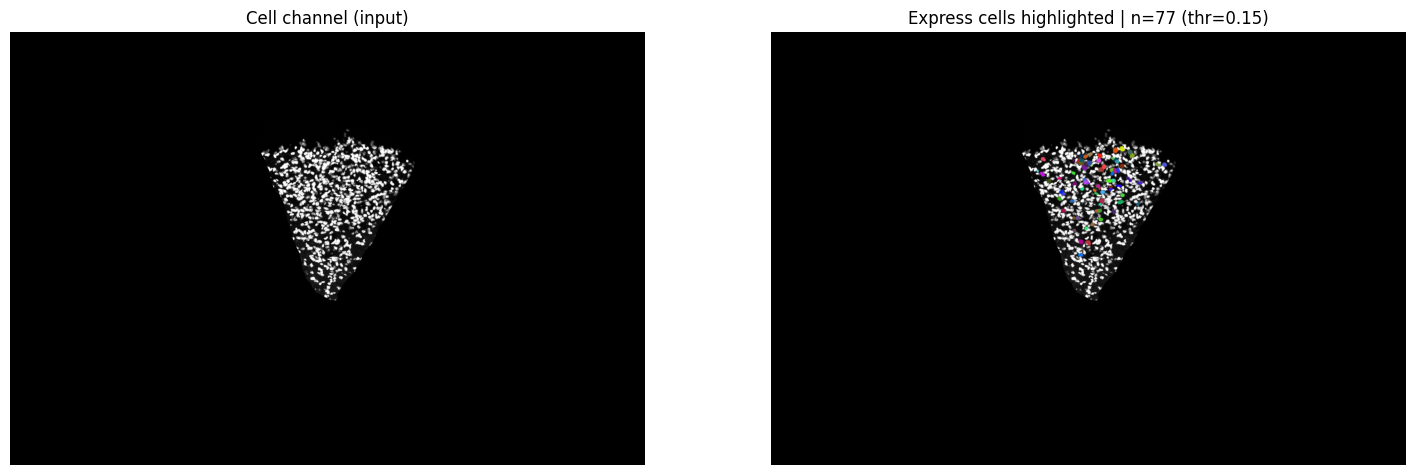

[SAVE] cell_results/test2_express_cells_thr15.png
[EXPRESS IDS sample] [31, 42, 53, 67, 73, 79, 85, 88, 94, 104, 108, 110, 115, 116, 117, 118, 127, 133, 139, 140]
[SAVE clean result] cell_results/test2_express_cells_clean_thr15.png


In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt

THRESH_EXPRESS = 0.15   # 15%
OUTPUT_DIR = "cell_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

cell_ids = np.unique(masks)
cell_ids = cell_ids[cell_ids != 0]  

cell_area = np.bincount(masks.ravel())

marker_u8 = marker_bin_p.astype(np.uint8)
marker_in_cell_area = np.bincount(masks.ravel(), weights=marker_u8.ravel())

ratios = {}
express_ids = []
for cid in cell_ids:
    a = cell_area[cid]
    if a <= 0:
        continue
    m = marker_in_cell_area[cid]
    r = float(m) / float(a)
    ratios[cid] = r
    if r >= THRESH_EXPRESS:
        express_ids.append(int(cid))

express_cells_count = len(express_ids)
print(f"[EXPRESS] threshold={THRESH_EXPRESS:.3f} | express_cells={express_cells_count} / total_cells={len(cell_ids)}")

def colorize_express_cells(instance_mask, express_id_list, seed=123):

    H, W = instance_mask.shape
    out = np.zeros((H, W, 3), dtype=np.uint8)
    if len(express_id_list) == 0:
        return out

    rng = np.random.default_rng(seed)
    colors = {}
    for cid in express_id_list:
        c = rng.integers(40, 256, size=3, dtype=np.uint8)
        k = int(rng.integers(0, 3))
        c[k] = rng.integers(0, 80, dtype=np.uint8)
        colors[cid] = c

    for cid in express_id_list:
        out[instance_mask == cid] = colors[cid]
    return out

express_rgb = colorize_express_cells(masks, express_ids, seed=123)

gray_u8 = (np.clip(cell_norm, 0, 1) * 255).astype(np.uint8)
base_rgb = np.stack([gray_u8, gray_u8, gray_u8], axis=-1)  # (H,W,3)

express_region = (express_rgb.sum(axis=-1) > 0)
result_rgb = base_rgb.copy()
result_rgb[express_region] = express_rgb[express_region]

base_name = "test2" 
out_png = os.path.join(OUTPUT_DIR, f"{base_name}_express_cells_thr{int(THRESH_EXPRESS*100):02d}.png")

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.imshow(cell_norm, cmap="gray")
plt.title("Cell channel (input)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(result_rgb)
plt.title(f"Express cells highlighted | n={express_cells_count} (thr={THRESH_EXPRESS:.2f})")
plt.axis("off")

plt.savefig(out_png, dpi=150, bbox_inches="tight")
plt.show()

print("[SAVE]", out_png)
print("[EXPRESS IDS sample]", express_ids[:20])

final_png = os.path.join(
    OUTPUT_DIR,
    f"{base_name}_express_cells_clean_thr{int(THRESH_EXPRESS*100):02d}.png"
)

plt.figure(figsize=(10, 10))
plt.imshow(result_rgb)
plt.axis("off")

plt.savefig(
    final_png,
    dpi=150,
    bbox_inches="tight",
    pad_inches=0
)
plt.close()

print("[SAVE clean result]", final_png)